# What are people watching on Netflix?
Who?
Where?
Why?


`imports`, I've seen this before!

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
from collections import defaultdict

Some magic that tells jupyter to put graphs and things in the notebook instead of the default behaviour which is to save it as a file.

In [3]:
%matplotlib inline

Set the size of the plots that will come out when we ask for them. Annoyingly, these are in inches. Whatever an "inch" is

In [4]:
plt.rcParams["figure.figsize"] = (10, 5)


In [5]:
saved_style_state = matplotlib.rcParams.copy()  # give us a style state to go back to


The following checks to see if we've already downloaded the data. It's a big file, so we don't want to do it every time we run the code. Even just loading from file takes a few seconds!

Pandas is pretty smart, it can get data from the internet just as easily as from the file system, it just takes a bit longer.

# Accessing the file

In [6]:
if os.path.isfile("all-weeks-countries.csv"):
    filepath = "all-weeks-countries.csv"
    print("loading from file")
else:
    filepath = "https://www.kaggle.com/datasets/dhruvildave/netflix-top-10-tv-shows-and-films?resource=download&select=all-weeks-countries.csv"
    print("loading from the internet")

netflix_data = pd.read_csv(filepath)
netflix_data=netflix_data[netflix_data['week']<='2022-02-27']
print("done")


loading from file
done


## Example row

In [7]:
netflix_data.iloc[0]

country_name                   Argentina
country_iso2                          AR
week                          2022-02-27
category                           Films
weekly_rank                            1
show_title                      Restless
season_title                         NaN
cumulative_weeks_in_top_10             1
Name: 500, dtype: object

# Creating a function to get movie genres

In [8]:
import requests

api_key = 'c60cd8e6dfbc3c4bfb0b63eda3108351'
base_url = 'https://api.themoviedb.org/3'

def get_genre(show_title, category):
    if category == 'Films':
        search_url = f"{base_url}/search/movie"
    elif category == 'TV':
        search_url = f"{base_url}/search/tv"
    else:
        return 'Unknown'

    params = {
        'api_key': api_key,
        'query': show_title
    }

    response = requests.get(search_url, params=params)
    results = response.json().get('results', [])
    
    if results:
        show_id = results[0]['id']
        if category == 'Films':
            show_details_url = f"{base_url}/movie/{show_id}"
        else:
            show_details_url = f"{base_url}/tv/{show_id}"
        
        show_details_response = requests.get(show_details_url, params={'api_key': api_key})
        show_details = show_details_response.json()
        genres = show_details.get('genres', [])
        genre_names = [genre['name'] for genre in genres]
        return genre_names
    else:
        return 'Unknown'

# TRYING TO MAKE A DICTIONARY OF GENRES

In [9]:
import json

unique_titles = netflix_data['show_title'].unique()
genres_dict = {}

if os.path.isfile("./genre_file.json"):
        file = open("./genre_file.json", "r")
        genres_dict = json.load(file)
else:
    for title in unique_titles:
        category = netflix_data[netflix_data['show_title'] == title]['category'].iloc[0]
        genres = get_genre(title, category)
        genres_dict[title] = genres
    with open("genre_file.json","w") as file:
        json.dump(genres_dict, file, indent=4)

# Add the genres into the original csv

In [10]:
netflix_data['genres']=netflix_data['show_title'].map(genres_dict)
netflix_data.to_csv('all-weeks-countries.csv', index=False)

In [11]:
netflix_data.genres.value_counts()

genres
[Drama]                                            8502
[Crime, Drama]                                     3149
[Comedy, Drama]                                    2806
[Comedy]                                           2248
[Romance, Comedy]                                  1431
                                                   ... 
[Action, Fantasy, Thriller]                           1
[Science Fiction, Fantasy, Action]                    1
[Animation, Comedy, Kids]                             1
[Family, Adventure, Comedy, Fantasy, Animation]       1
[Action, Crime, Mystery]                              1
Name: count, Length: 733, dtype: int64

## NEW Example Row

In [12]:
netflix_data.iloc[0]

country_name                         Argentina
country_iso2                                AR
week                                2022-02-27
category                                 Films
weekly_rank                                  1
show_title                            Restless
season_title                               NaN
cumulative_weeks_in_top_10                   1
genres                        [Drama, Romance]
Name: 500, dtype: object

The .value_counts() will create a series, where (using below as an example), index is the show name and value is the numerical value assigned ot the show name

In [13]:
count_of_shows=netflix_data["show_title"].value_counts() 
count_of_shows

show_title
Money Heist                        1592
The Good Doctor                    1498
Squid Game                         1194
You                                 950
The Witcher                         883
                                   ... 
Crime Stories: India Detectives       1
Tughlaq Durbar (Telugu)               1
Roohi                                 1
The Devil's Advocate                  1
Glitch                                1
Name: count, Length: 2299, dtype: int64

<Axes: xlabel='show_title'>

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49800 (\N{HANGUL SYLLABLE SYU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51592 (\N{HANGUL SYLLABLE JEU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47112 

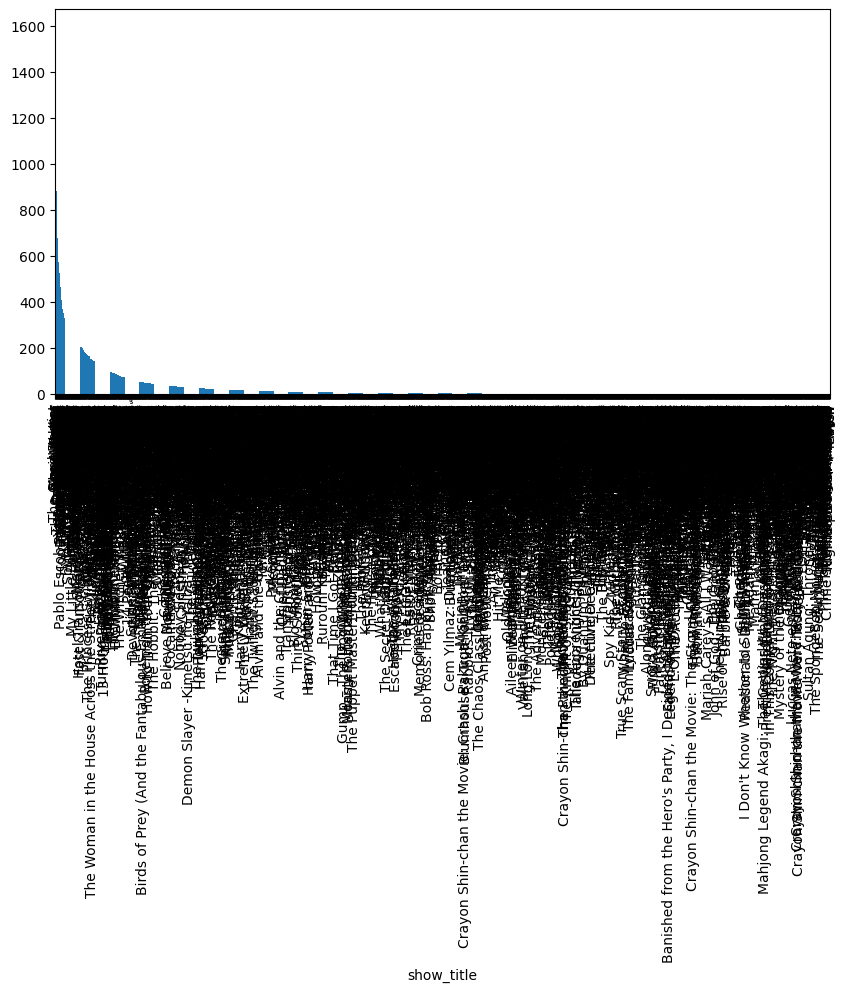

In [14]:
count_of_shows.plot(kind="bar")

the below only plots the tv shows that show up for a specific number of times

<Axes: ylabel='show_title'>

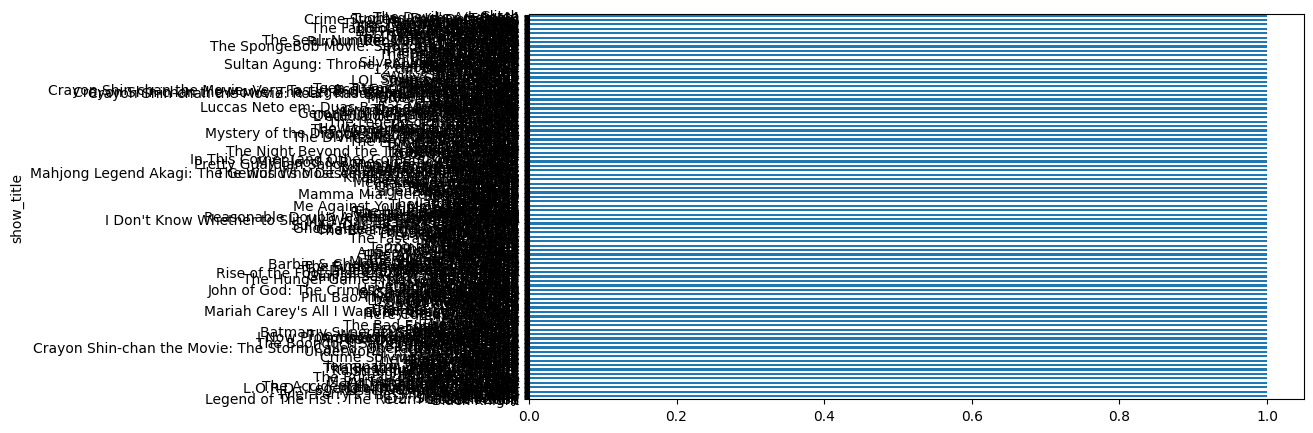

In [15]:
count_of_shows[count_of_shows ==1].plot(kind="barh")

the below code creates the same horizontal bar graph

<BarContainer object of 472 artists>

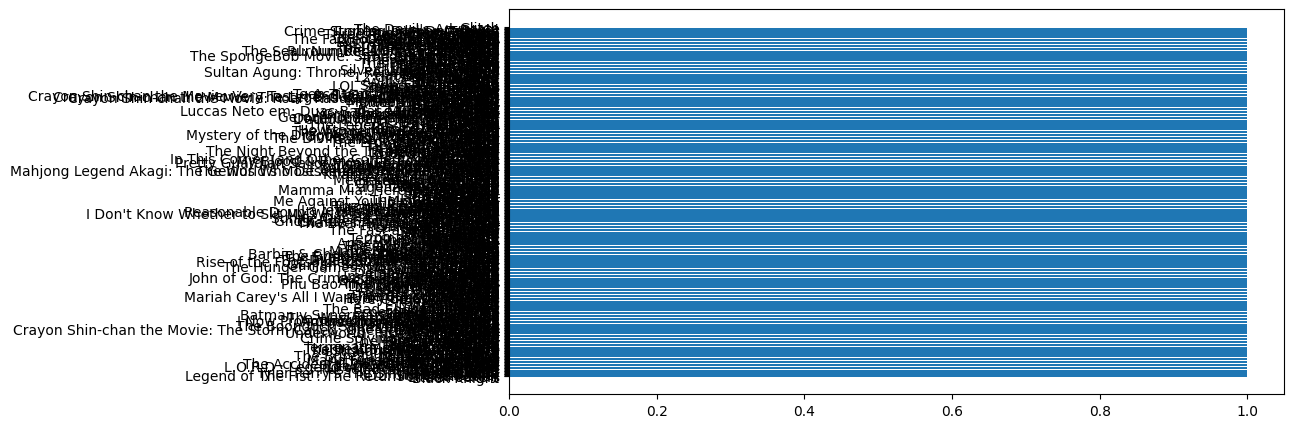

In [16]:
plt.barh(count_of_shows[count_of_shows==1].index,count_of_shows[count_of_shows==1].values)

The below kinda parses the dates so that the code recognises the date in the column "week"

In [17]:
netflix_data = pd.read_csv(
    filepath,
    infer_datetime_format=True,
    parse_dates=["week"],
)
netflix_data.head(2)


/var/folders/m6/9l2c43w54_dcl4z2zjrmxh940000gn/T/ipykernel_98808/3425564230.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  netflix_data = pd.read_csv(


,country_name,country_iso2,week,category,weekly_rank,show_title,season_title,cumulative_weeks_in_top_10,genres
0,Argentina,AR,2022-02-27,Films,1,Restless,NaN,1,"['Drama', 'Romance']"
1,Argentina,AR,2022-02-27,Films,2,Parallel Mothers,NaN,2,['Drama']


Then it finds the max and min date

In [18]:
first_date = netflix_data.week.min()
last_date = netflix_data.week.max()
f"range is: {first_date} to {last_date}"


'range is: 2021-07-04 00:00:00 to 2022-02-27 00:00:00'

This makes it much more readable 

In [19]:
date_format_pattern = "%B, %Y"
earliest_date = datetime.strftime(first_date, date_format_pattern)
latest_date = datetime.strftime(last_date, date_format_pattern)
f"range is: {earliest_date} to {latest_date}"

'range is: July, 2021 to February, 2022'

The below(first line) shows how to filter the data to make a graph

<BarContainer object of 40 artists>

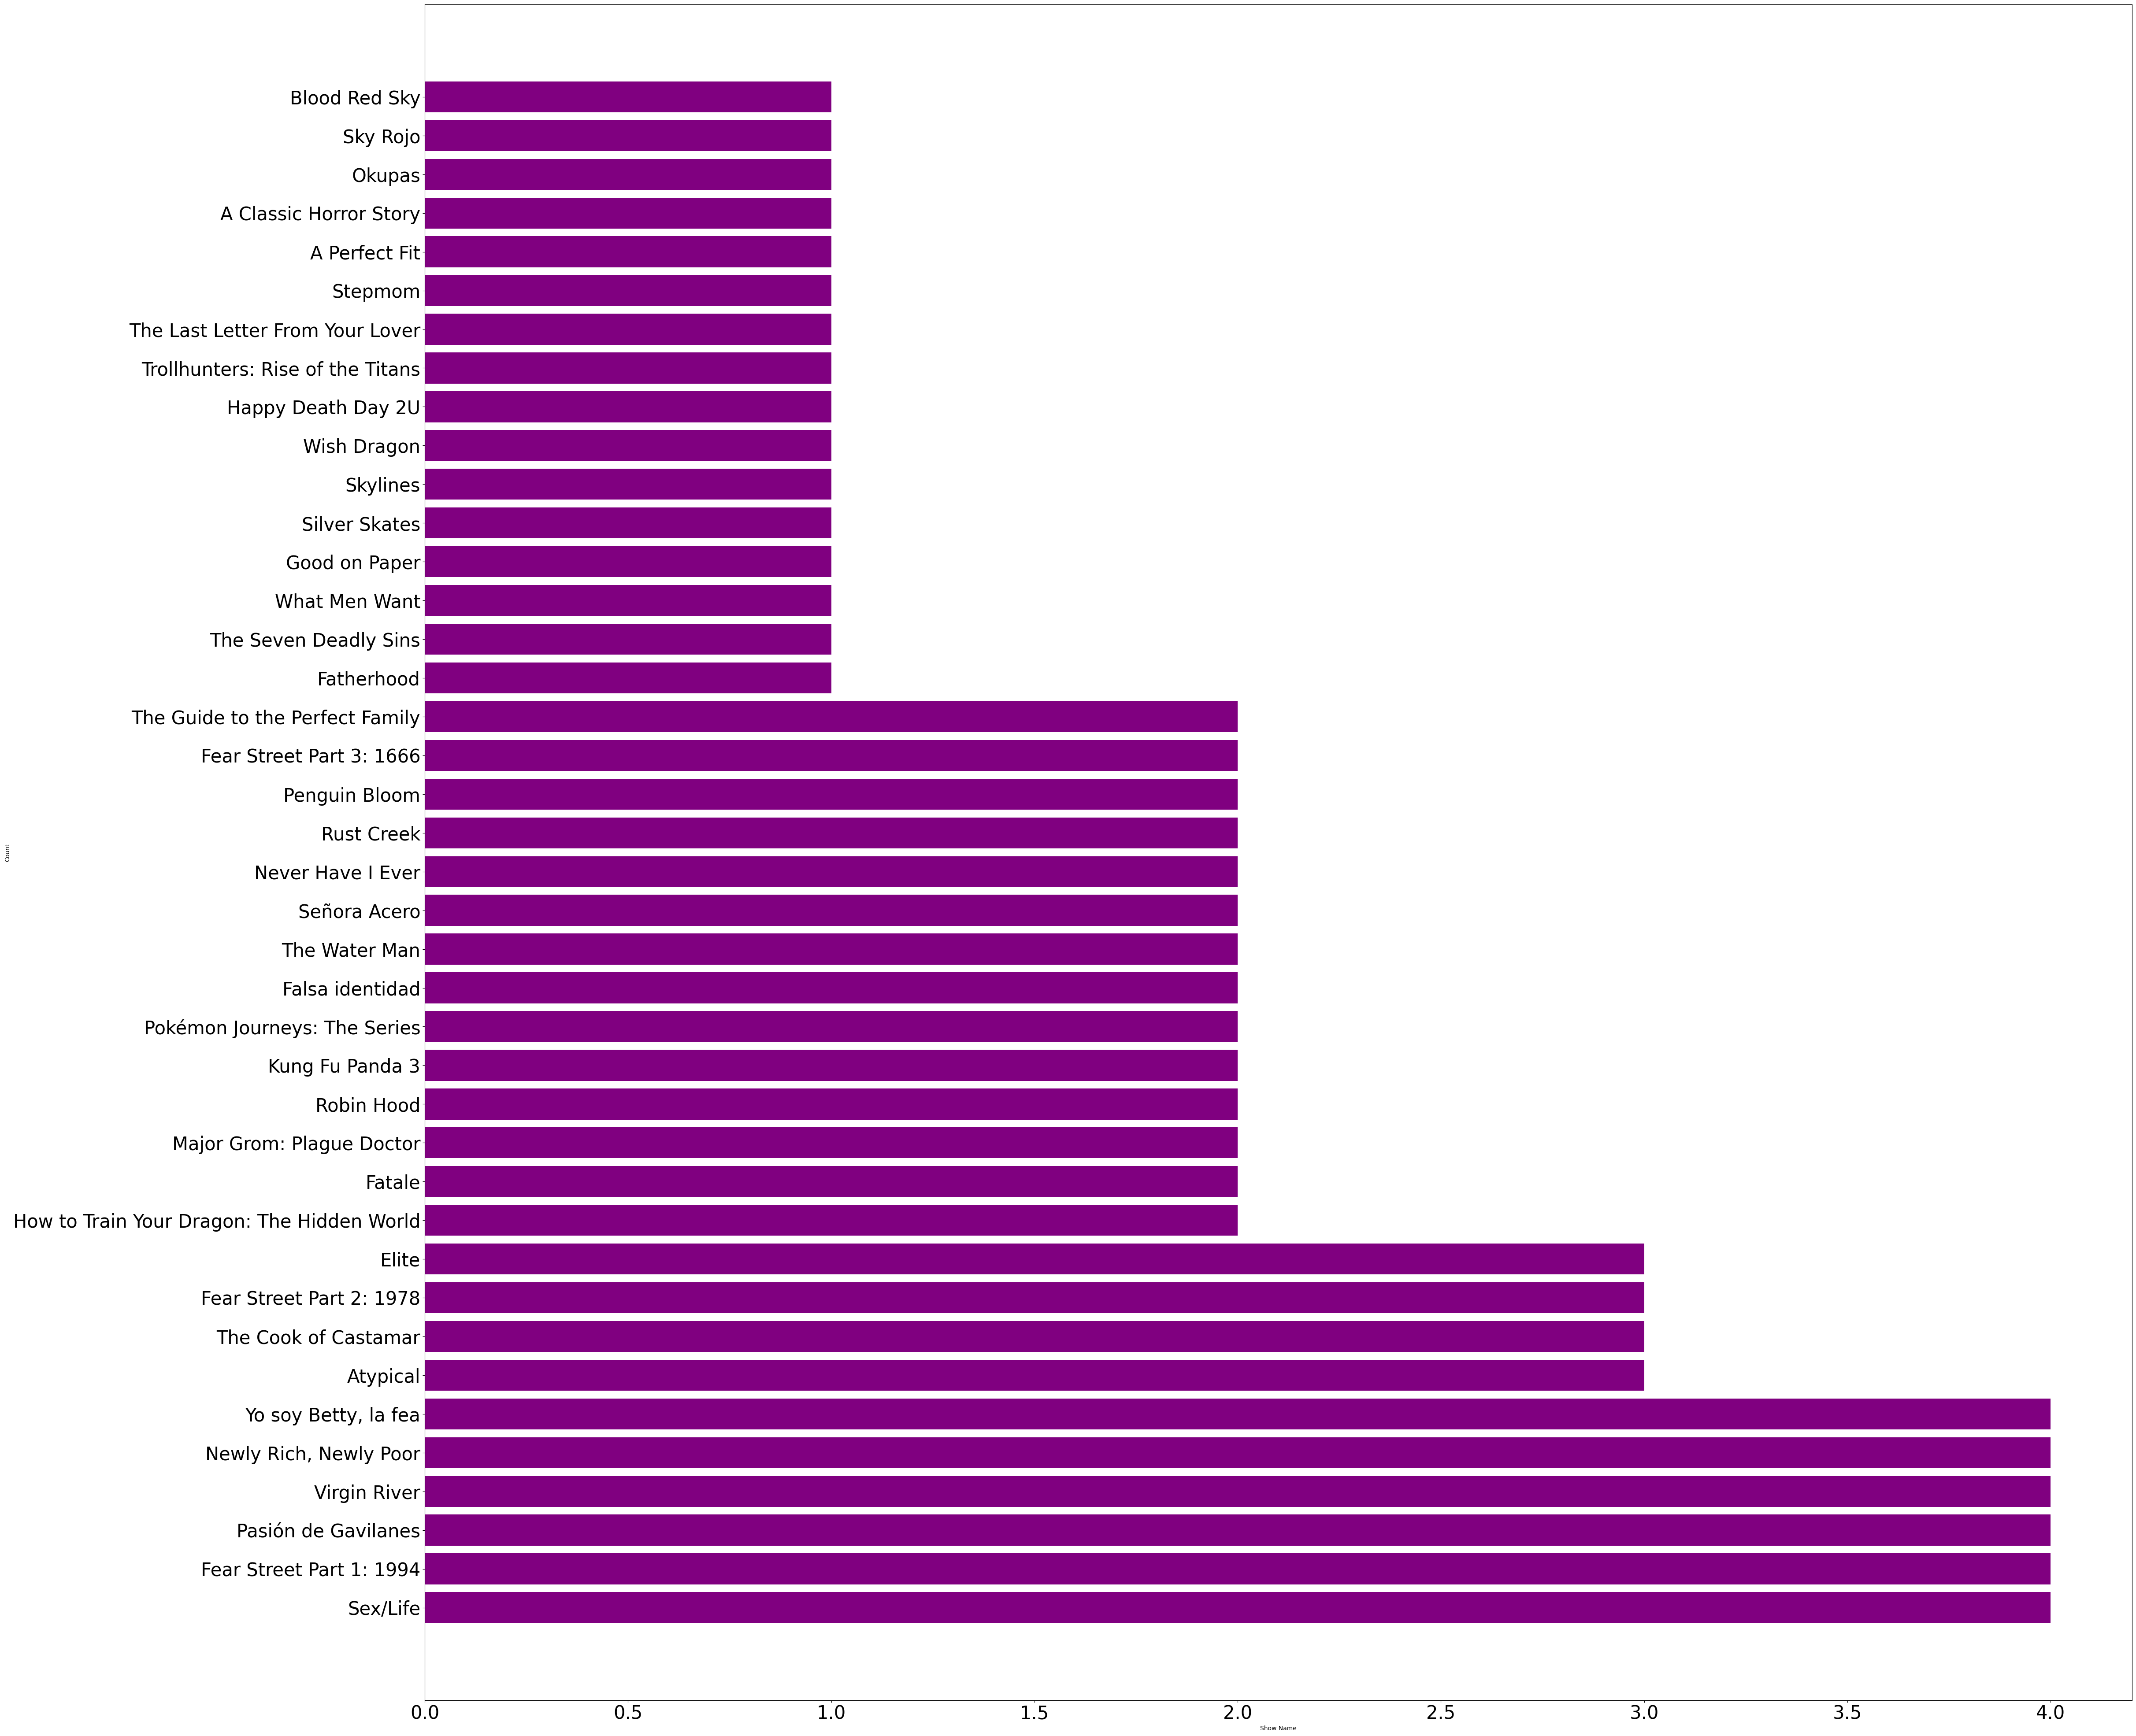

In [20]:
filtered_data = netflix_data[(netflix_data['week'] <="2021-07-30") & (netflix_data['week'] >="2021-07-04")&(netflix_data['country_name']=="Argentina")]
show_counts = filtered_data['show_title'].value_counts() 
plt.figure(figsize=(50, 50))
plt.xlabel('Show Name')
plt.ylabel('Count')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)  
plt.barh(show_counts.index, show_counts.values, color='purple')

<BarContainer object of 20 artists>

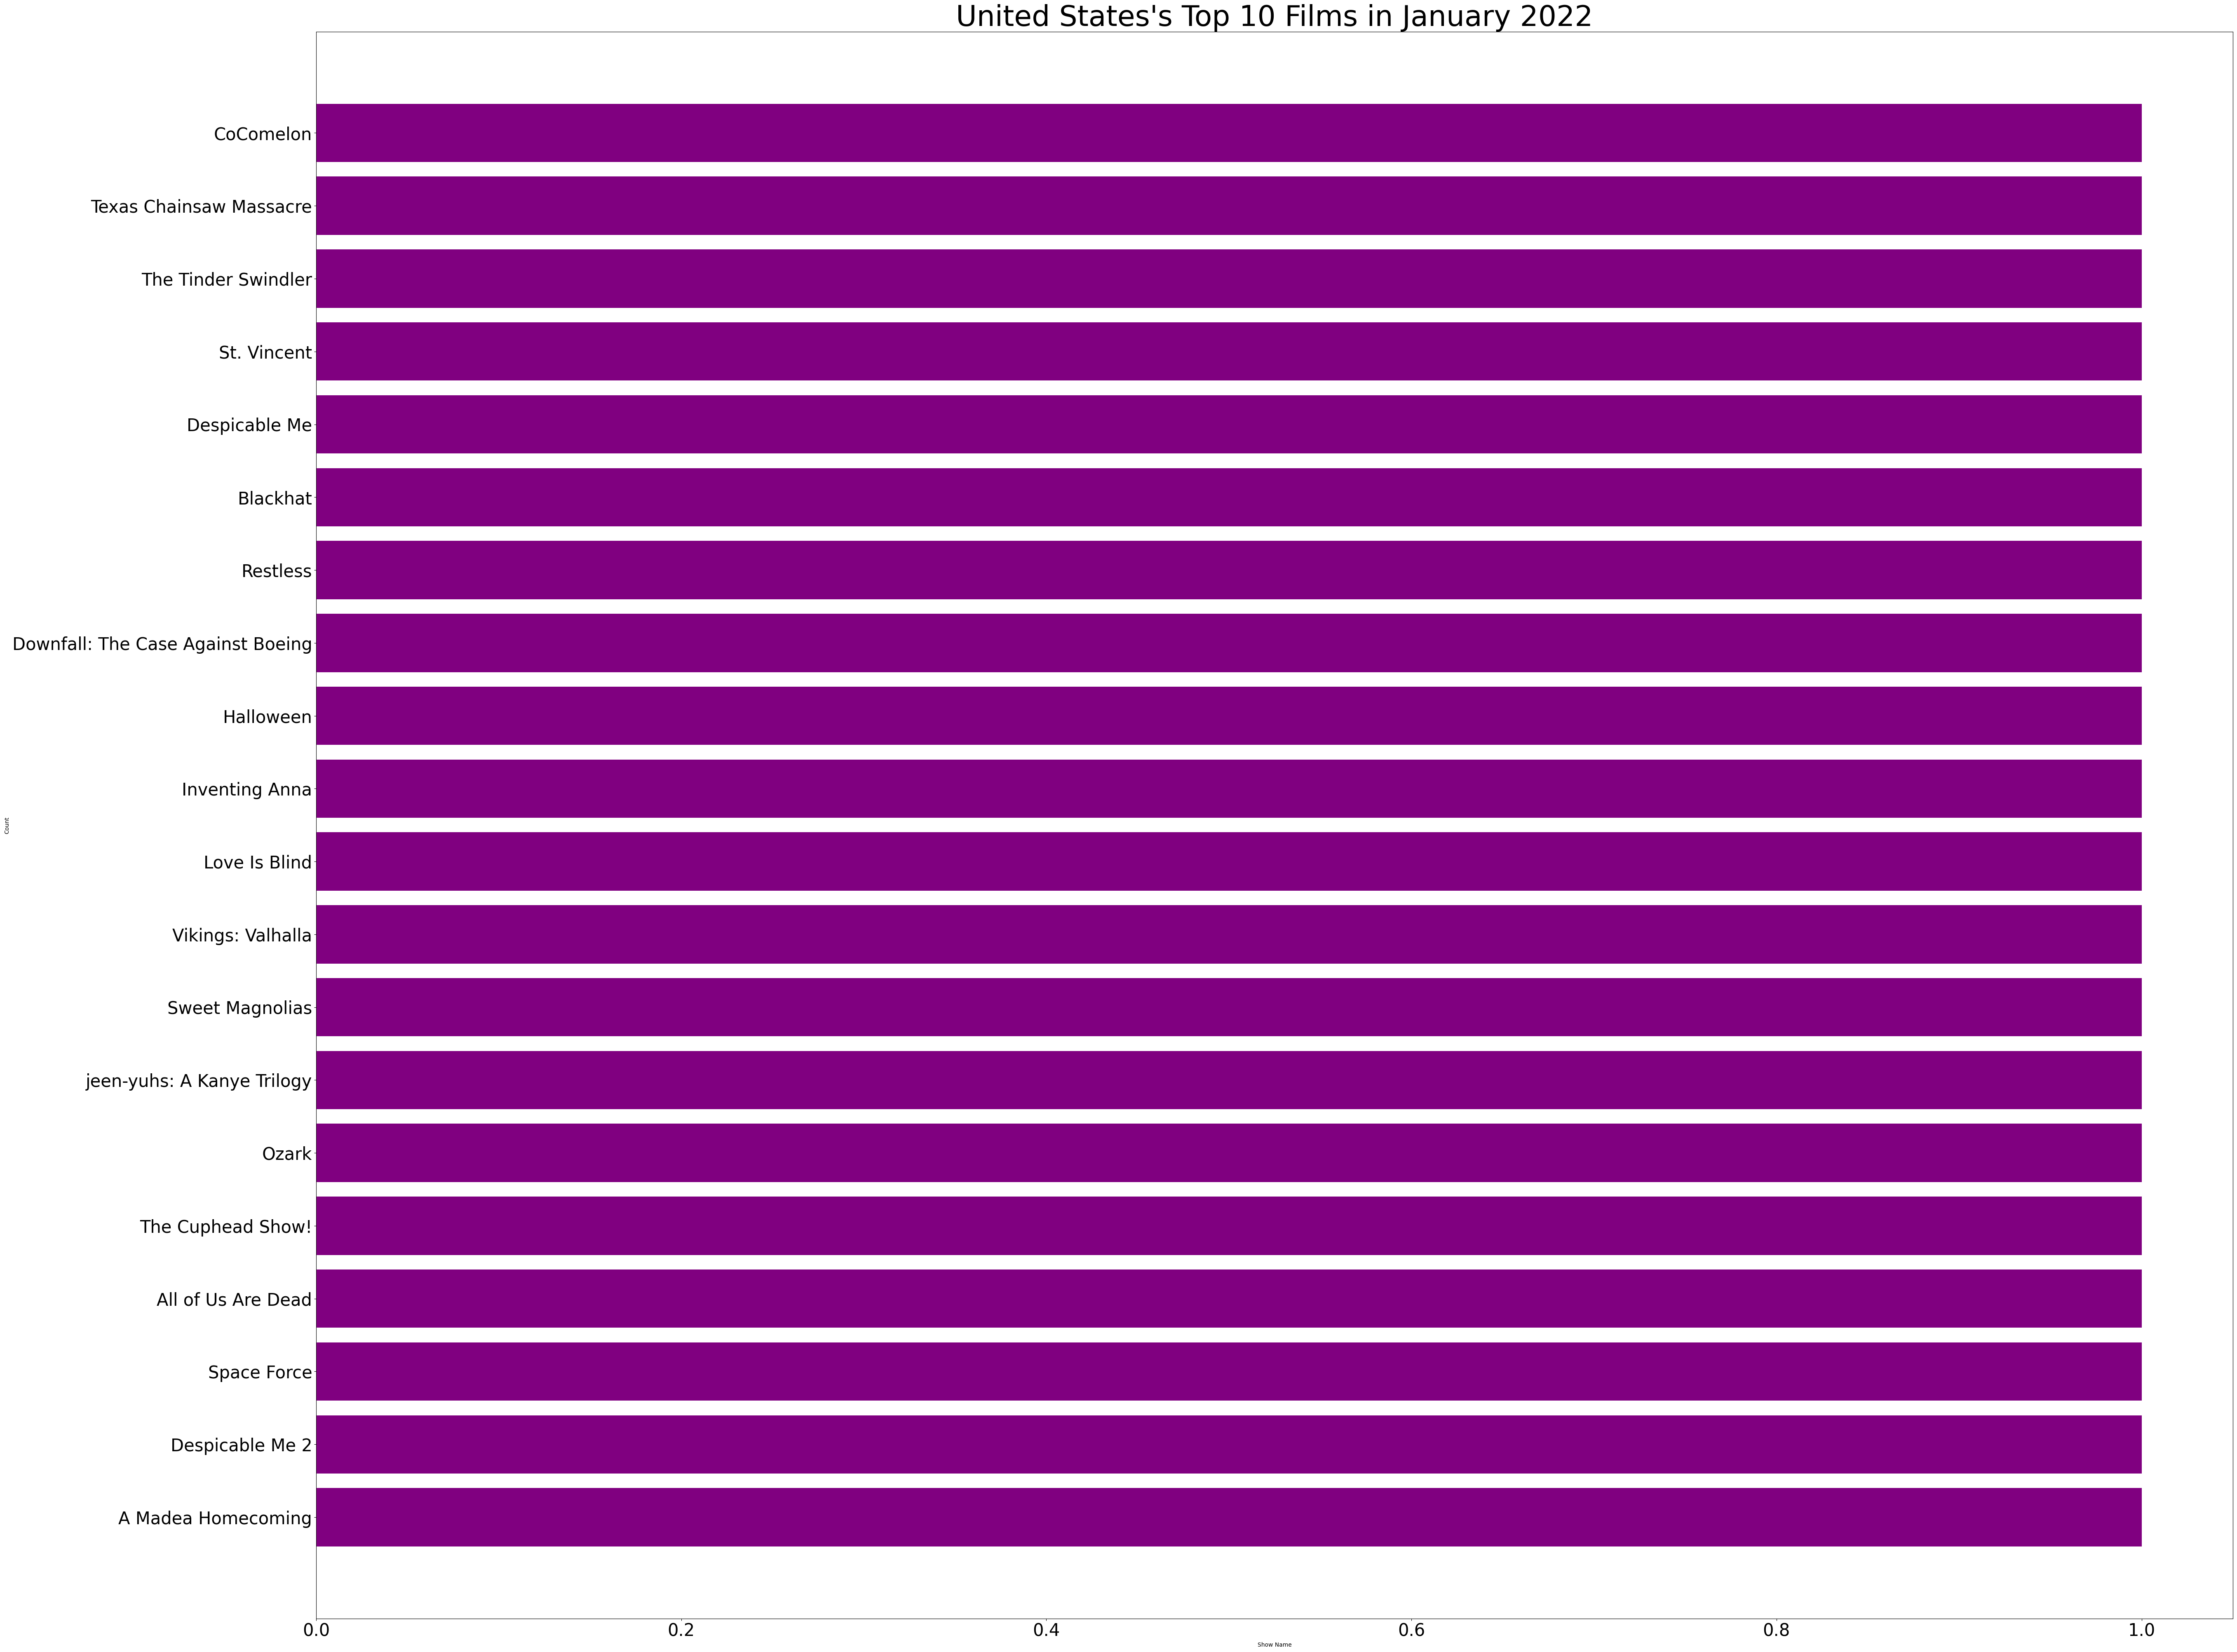

In [21]:
country= 'United States'
filtered_data = netflix_data[(netflix_data['week'] <"2022-03-27") & (netflix_data['week'] >="2022-02-27")&(netflix_data['country_name']==country)]
show_counts = filtered_data['show_title'].value_counts() 
plt.figure(figsize=(60, 50))
plt.xlabel('Show Name')
plt.ylabel('Count')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title(label=f"{country}'s Top 10 Films in January 2022", fontsize=50)  
plt.barh(show_counts.index, show_counts.values, color='purple')

# GROUPBY

In [22]:
for name, df in netflix_data.groupby("country_name"):
#netflix_data.groupby("country_name") creates a grouped object where netflix_data is split into groups based on unique values in the "country_name" column.
#The for name, df in ... part iterates over each group produced by groupby("country_name").
# name represents the unique value from the "country_name" column that defines the current group.
# df represents only the rows where "country_name" matches name.
    popular=df[df.cumulative_weeks_in_top_10>=52] #filters the dataframe to select rows where the "cumulative_weeks_in_top_10" column has values greater than 45.
    if popular.shape[0]: #shape[0] gives the number of rows, in this context it checks if popular has any rows
        titles = popular.show_title.unique() #Retrieves unique values from the 'show_title' column of the popular DataFrame.
        print(name, df.shape, titles, len(titles))
        #df.shape: Shape of the original DataFrame subset (df), which includes the number of rows and columns.
        #len(titles): Number of unique show titles in popular
        #print(popular[["show_title","cumulative_weeks_in_top_10"]])
        

In [23]:
for week, row in netflix_data.groupby("week"):
    popular=row[row.cumulative_weeks_in_top_10==37]
    print(week, popular.show_title.unique())

2021-07-04 00:00:00 []
2021-07-11 00:00:00 []
2021-07-18 00:00:00 []
2021-07-25 00:00:00 []
2021-08-01 00:00:00 []
2021-08-08 00:00:00 []
2021-08-15 00:00:00 []
2021-08-22 00:00:00 []
2021-08-29 00:00:00 []
2021-09-05 00:00:00 []
2021-09-12 00:00:00 []
2021-09-19 00:00:00 []
2021-09-26 00:00:00 []
2021-10-03 00:00:00 []
2021-10-10 00:00:00 []
2021-10-17 00:00:00 []
2021-10-24 00:00:00 []
2021-10-31 00:00:00 []
2021-11-07 00:00:00 []
2021-11-14 00:00:00 []
2021-11-21 00:00:00 []
2021-11-28 00:00:00 []
2021-12-05 00:00:00 []
2021-12-12 00:00:00 []
2021-12-19 00:00:00 []
2021-12-26 00:00:00 []
2022-01-02 00:00:00 []
2022-01-09 00:00:00 []
2022-01-16 00:00:00 []
2022-01-23 00:00:00 []
2022-01-30 00:00:00 []
2022-02-06 00:00:00 []
2022-02-13 00:00:00 []
2022-02-20 00:00:00 []
2022-02-27 00:00:00 []


In [24]:
netflix_data.iloc[0]

country_name                             Argentina
country_iso2                                    AR
week                           2022-02-27 00:00:00
category                                     Films
weekly_rank                                      1
show_title                                Restless
season_title                                   NaN
cumulative_weeks_in_top_10                       1
genres                        ['Drama', 'Romance']
Name: 0, dtype: object

# Counting how much drama shows each country has

In [25]:
current_high=0
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Drama' in genres for genres in df['genres'] ]
    dramatic = df[mask]
    if len(dramatic)>=current_high:
        current_high=len(dramatic)
        dramatic_country=name
print (f"{dramatic_country} is the MOST DRAMATIC COUNTRY!! They watched {current_high} drama shows. Taiwan is omitted from ") 

current_low=10000
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Drama' in genres for genres in df['genres'] ]
    dramatic = df[mask]
    if len(dramatic)<=current_low:
        current_low=len(dramatic)
        xdramatic_country=name
print (f"{xdramatic_country} is the LEAST DRAMATIC COUNTRY!! They watched {current_low} drama shows")

Taiwan is the MOST DRAMATIC COUNTRY!! They watched 460 drama shows. Taiwan is omitted from 
Estonia is the LEAST DRAMATIC COUNTRY!! They watched 306 drama shows


In [26]:
current_high=0
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Comedy' in genres for genres in df['genres'] ]
    funny = df[mask]
    if len(funny)>=current_high:
        current_high=len(funny)
        funny_country=name
print (f"{funny_country} is the MOST FUNNY COUNTRY!! They watched {current_high} comedy shows")

current_low=10000
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Comedy' in genres for genres in df['genres'] ]
    funny = df[mask]
    if len(funny)<=current_low:
        current_low=len(funny)
        xfunny_country=name
print (f"{xfunny_country} is the LEAST FUNNY COUNTRY!! They watched {current_low} comedy shows")

Latvia is the MOST FUNNY COUNTRY!! They watched 331 comedy shows
Oman is the LEAST FUNNY COUNTRY!! They watched 131 comedy shows


# Create ranking

## Drama

In [27]:
current_high=0
dramatic_dict=[]
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Drama' in genres for genres in df['genres'] ]
    dramatic = df[mask]
    dramatic_dict.append({'country_name': name, 'drama_count': len(dramatic)})

dramatic_df = pd.DataFrame(dramatic_dict)
sorted_dramatic_df = dramatic_df.sort_values(by='drama_count',ascending=False)
print(sorted_dramatic_df.to_string(index=False)) #convert a DataFrame or Series into a string representation

        country_name  drama_count
              Taiwan          460
           Venezuela          456
                Oman          456
           Indonesia          452
             Nigeria          450
           Argentina          449
               Chile          443
           Sri Lanka          441
           Nicaragua          441
             Morocco          441
          Costa Rica          439
          Bangladesh          438
         Philippines          438
             Vietnam          436
             Uruguay          435
            Paraguay          434
            Pakistan          433
            Honduras          433
            Portugal          432
                Peru          430
               Italy          427
               Malta          427
         El Salvador          426
              Russia          423
               India          422
  Dominican Republic          421
             Romania          421
            Malaysia          420
             B

## Comedy

In [28]:
current_high=0
funny_dict=[]
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Comedy' in genres for genres in df['genres'] ]
    funny = df[mask]
    funny_dict.append({'country_name': name, 'funny_count': len(funny)})

funny_df = pd.DataFrame(funny_dict)
sorted_funny_df = funny_df.sort_values(by='funny_count',ascending=False)
print(sorted_funny_df.to_string(index=False)) #convert a DataFrame or Series into a string representation

        country_name  funny_count
              Latvia          331
           Lithuania          329
             Estonia          302
            Slovenia          289
             Bolivia          284
              Jordan          274
             Vietnam          270
           Guatemala          269
              Mexico          262
            Colombia          262
             Croatia          259
            Thailand          255
          Costa Rica          254
            Honduras          252
              Serbia          251
             Ecuador          249
            Bulgaria          247
             Iceland          246
         El Salvador          245
           Nicaragua          244
            Slovakia          241
      United Kingdom          241
              Panama          240
               Chile          235
           Indonesia          235
            Paraguay          234
             Ukraine          233
      Czech Republic          232
              

## Romance

In [29]:
current_high=0
romantic_dict=[]
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Romance' in genres for genres in df['genres'] ]
    romance = df[mask]
    romantic_dict.append({'country_name': name, 'romantic_count': len(romance)})

romantic_df = pd.DataFrame(romantic_dict)
sorted_romantic_df = romantic_df.sort_values(by='romantic_count',ascending=False)
print(sorted_romantic_df.to_string(index=False)) #convert a DataFrame or Series into a string representation

        country_name  romantic_count
               India             107
          Bangladesh              90
           Sri Lanka              88
             Lebanon              86
           Mauritius              83
            Maldives              83
             Nigeria              78
            Pakistan              77
           Lithuania              77
             Romania              77
            Bulgaria              75
              Serbia              75
             Hungary              74
        South Africa              71
          Martinique              71
           Nicaragua              70
             Croatia              70
          Guadeloupe              70
            Paraguay              69
               Italy              69
            Honduras              69
              Cyprus              68
            Portugal              68
            Slovenia              68
 Trinidad and Tobago              68
           Guatemala              67
 

## Action

In [30]:
current_high=0
action_dict=[]
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Action' in genres for genres in df['genres'] ]
    action = df[mask]
    action_dict.append({'country_name': name, 'action_count': len(action)})

action_df = pd.DataFrame(action_dict)
sorted_action_df = action_df.sort_values(by='action_count',ascending=False)
print(sorted_action_df.to_string(index=False))

        country_name  action_count
                Oman           361
             Vietnam           301
            Thailand           287
       New Caledonia           275
            Malaysia           270
        Saudi Arabia           267
           Hong Kong           264
             Jamaica           263
               Japan           260
           Singapore           254
              Kuwait           253
           Indonesia           247
          Guadeloupe           242
          Martinique           241
 Trinidad and Tobago           240
             Morocco           238
             Bahrain           236
               Qatar           236
             Réunion           234
         New Zealand           231
United Arab Emirates           229
         South Korea           229
           Mauritius           227
         Philippines           226
              Taiwan           224
              France           223
            Bulgaria           222
            Pakistan

# Create map

# Dealing with some names

In [42]:
# Create a mapping dictionary to eliminate name discrepancies
name_mapping = {
    'United States': 'United States of America', 'Serbia': 'Republic of Serbia','Czech Republic':'Czechia', 'Bahamas':'The Bahamas'}

# Apply the mapping to your DataFrame
dramatic_df['country_name'] = dramatic_df['country_name'].map(name_mapping).fillna(dramatic_df['country_name'])
missing_in_world = dramatic_df[~dramatic_df['country_name'].isin(world['SOVEREIGNT'])]

print("Missing in world GeoDataFrame:")
print(missing_in_world)

Missing in world GeoDataFrame:
     country_name  drama_count
27     Guadeloupe          403
30      Hong Kong          415
50     Martinique          399
55  New Caledonia          401
71        Réunion          383


In [43]:
missing_in_df = world[~world['SOVEREIGNT'].isin(dramatic_df['country_name'])]

print("Missing in dramatic_df:")
print(missing_in_df[['SOVEREIGNT']])

Missing in dramatic_df:
      SOVEREIGNT
0       Zimbabwe
1         Zambia
2          Yemen
5        Vatican
6        Vanuatu
..           ...
236      Albania
237  Afghanistan
238      Kashmir
239   Antarctica
241       Tuvalu

[114 rows x 1 columns]


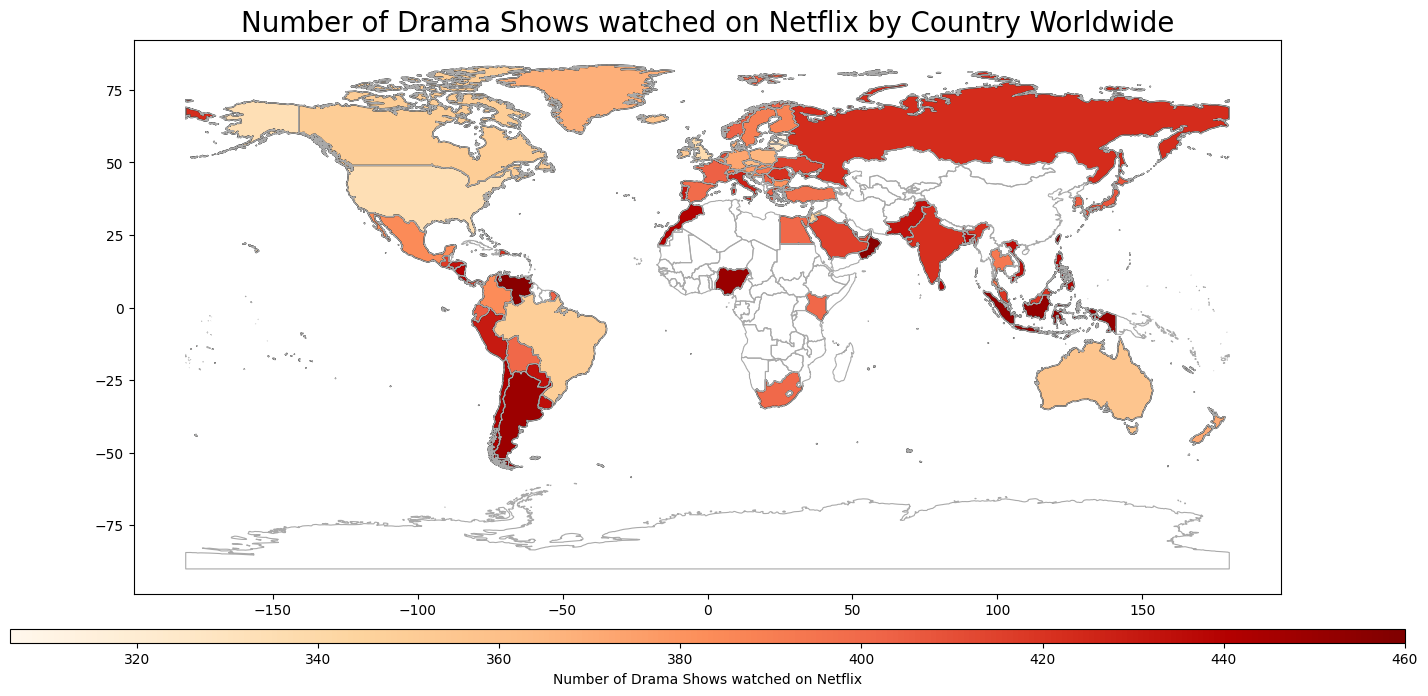

In [34]:
import geopandas as gpd
world = gpd.read_file('/Users/denyceng/CODE1161dataproject/ne_50m_admin_0_countries')

# merges the world GeoDataFrame with another DataFrame called dramatic_df. 
# The merge is done on the columns 'SOVEREIGNT' from world and 'country_name' from dramatic_df. 
# The how='left' argument means that all rows from the world dataset will be retained, and only matching rows from dramatic_df will be added
world = world.merge(dramatic_df, left_on='SOVEREIGNT', right_on='country_name', how='left') #

fig, ax = plt.subplots(1, 1, figsize=(18, 9)) #creates a Matplotlib figure (fig) and a set of axes (ax).
world.boundary.plot(ax=ax,edgecolor= 'darkgray',lw=0.8) #plots the boundaries of the geometries from GeoDataFrame on axes. This step outlines the countries borders.
world.plot(column='drama_count', #specifies the column in the GeoDataFrame to use for coloring the map. Here, it's likely a count of drama shows.
           ax=ax,
           legend=True, #adds a legend (colorbar) to the plot
           cmap='OrRd', #sets the colormap to "Orange-Red,"
           edgecolor='black',
           legend_kwds={'label': "Number of Drama Shows watched on Netflix",
                        'orientation': "horizontal",'pad':0.05, 'aspect':100, 'spacing':'proportional'}) # It sets the label of the colorbar and makes the orientation of the legend horizontal.
ax.tick_params(axis='both', labelsize=10) #sets the font size of the tick labels on X and Y axis to 45.

plt.title('Number of Drama Shows watched on Netflix by Country Worldwide',fontsize=20)
plt.show()

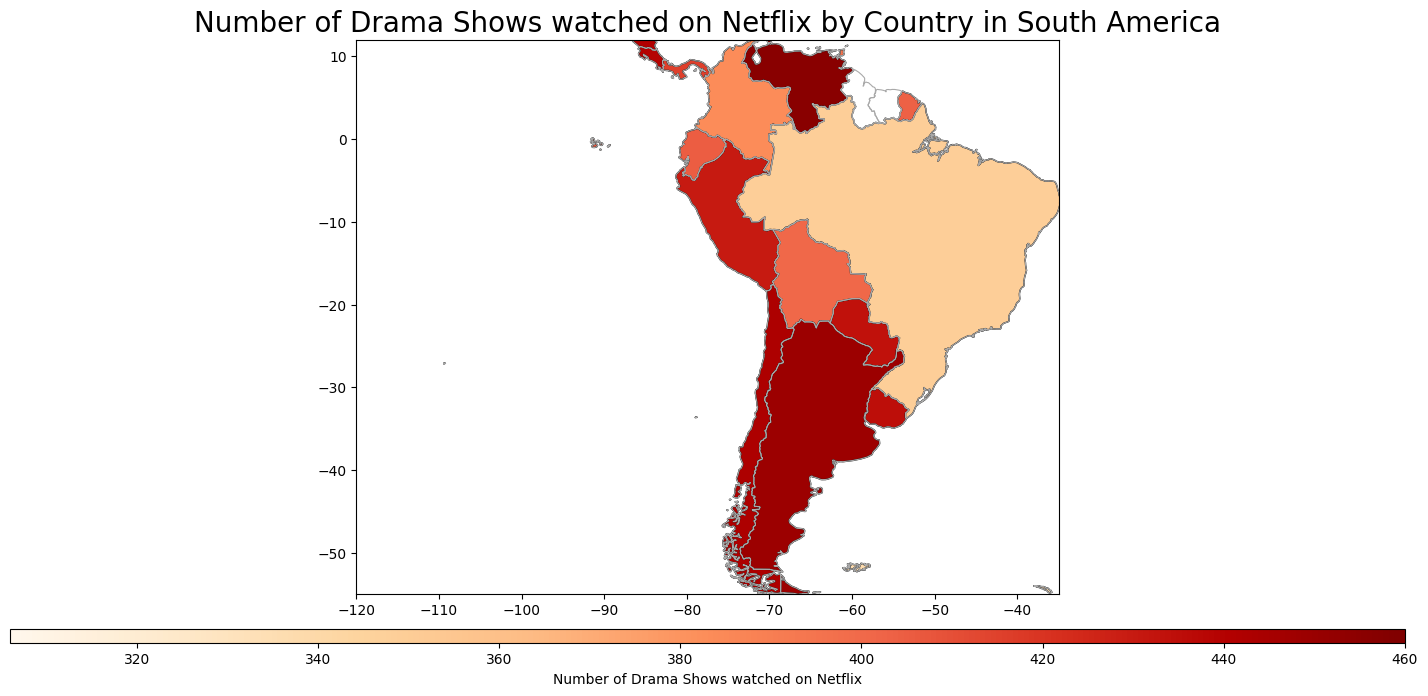

In [35]:

world = gpd.read_file('/Users/denyceng/CODE1161dataproject/ne_50m_admin_0_countries')

# merges the world GeoDataFrame with another DataFrame called dramatic_df. 
# The merge is done on the columns 'SOVEREIGNT' from world and 'country_name' from dramatic_df. 
# The how='left' argument means that all rows from the world dataset will be retained, and only matching rows from dramatic_df will be added
world = world.merge(dramatic_df, left_on='SOVEREIGNT', right_on='country_name', how='left') #

fig, ax = plt.subplots(1, 1, figsize=(18, 9)) #creates a Matplotlib figure (fig) and a set of axes (ax).
world.boundary.plot(ax=ax,edgecolor= 'darkgray',lw=0.8) #plots the boundaries of the geometries from GeoDataFrame on axes. This step outlines the countries borders.
world.plot(column='drama_count', #specifies the column in the GeoDataFrame to use for coloring the map. Here, it's likely a count of drama shows.
           ax=ax,
           legend=True, #adds a legend (colorbar) to the plot
           cmap='OrRd', #sets the colormap to "Orange-Red,"
           edgecolor='black',
           legend_kwds={'label': "Number of Drama Shows watched on Netflix",
                        'orientation': "horizontal",'pad':0.05, 'aspect':100, 'spacing':'proportional'}) # It sets the label of the colorbar and makes the orientation of the legend horizontal.
ax.tick_params(axis='both', labelsize=10) #sets the font size of the tick labels on X and Y axis to 45.
ax.set_ylim([-55, 12])  # Longitude range for continent
ax.set_xlim([-120, -35])
plt.title('Number of Drama Shows watched on Netflix by Country in South America',fontsize=20)
plt.show()

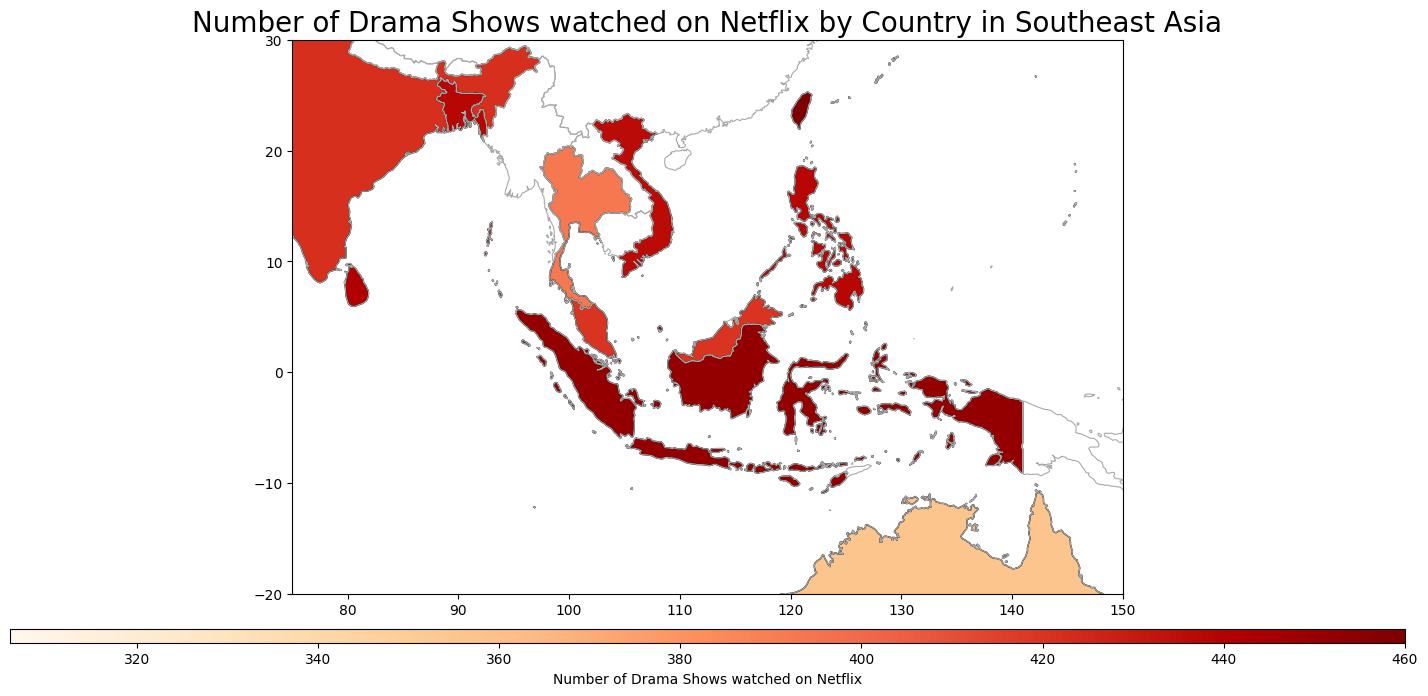

In [36]:

world = gpd.read_file('/Users/denyceng/CODE1161dataproject/ne_50m_admin_0_countries')

# merges the world GeoDataFrame with another DataFrame called dramatic_df. 
# The merge is done on the columns 'SOVEREIGNT' from world and 'country_name' from dramatic_df. 
# The how='left' argument means that all rows from the world dataset will be retained, and only matching rows from dramatic_df will be added
world = world.merge(dramatic_df, left_on='SOVEREIGNT', right_on='country_name', how='left') #

fig, ax = plt.subplots(1, 1, figsize=(18, 9)) #creates a Matplotlib figure (fig) and a set of axes (ax).
world.boundary.plot(ax=ax,edgecolor= 'darkgray',lw=0.8) #plots the boundaries of the geometries from GeoDataFrame on axes. This step outlines the countries borders.
world.plot(column='drama_count', #specifies the column in the GeoDataFrame to use for coloring the map. Here, it's likely a count of drama shows.
           ax=ax,
           legend=True, #adds a legend (colorbar) to the plot
           cmap='OrRd', #sets the colormap to "Orange-Red,"
           edgecolor='black',
           legend_kwds={'label': "Number of Drama Shows watched on Netflix",
                        'orientation': "horizontal",'pad':0.05, 'aspect':100, 'spacing':'proportional'}) # It sets the label of the colorbar and makes the orientation of the legend horizontal.
ax.tick_params(axis='both', labelsize=10) #sets the font size of the tick labels on X and Y axis to 45.
ax.set_xlim([75, 150])  # Longitude range for continent
ax.set_ylim([-20, 30]) #latitude range for continent
plt.title('Number of Drama Shows watched on Netflix by Country in Southeast Asia',fontsize=20)
plt.show()

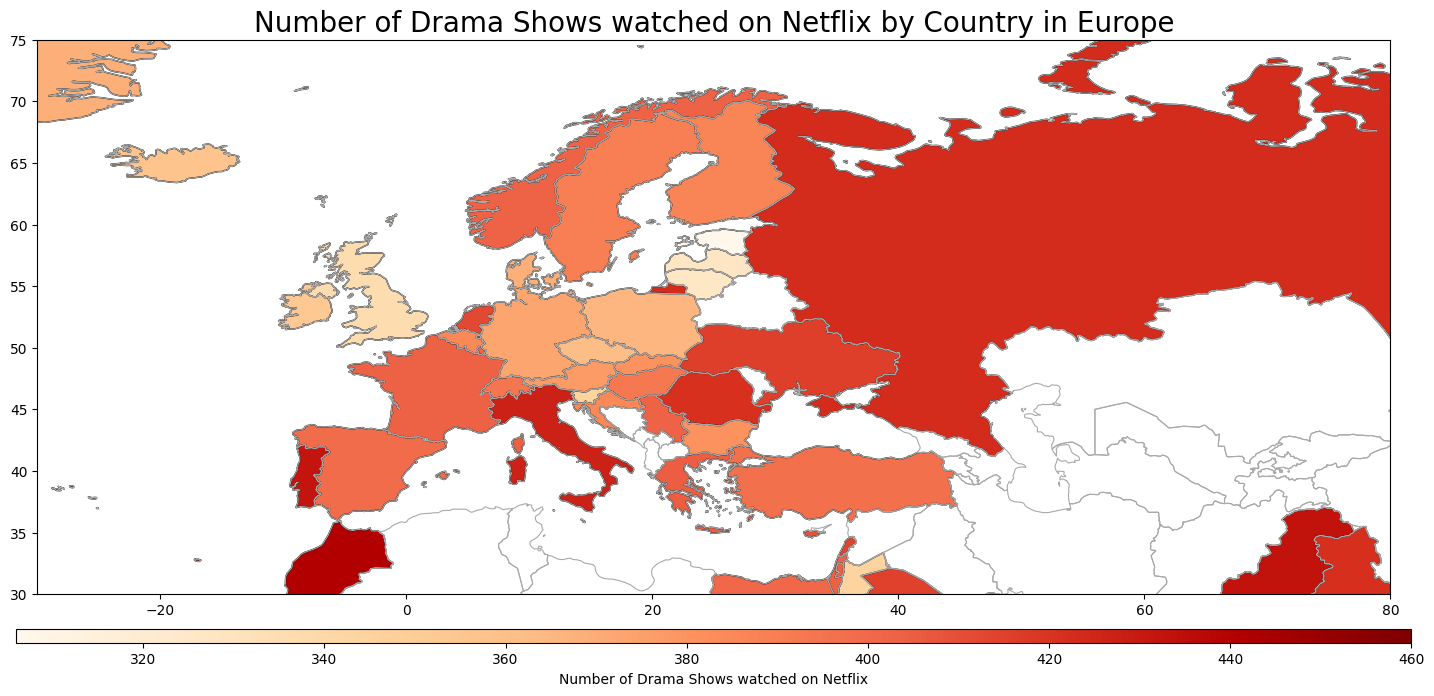

In [37]:
world = gpd.read_file('/Users/denyceng/CODE1161dataproject/ne_50m_admin_0_countries')

# merges the world GeoDataFrame with another DataFrame called dramatic_df. 
# The merge is done on the columns 'SOVEREIGNT' from world and 'country_name' from dramatic_df. 
# The how='left' argument means that all rows from the world dataset will be retained, and only matching rows from dramatic_df will be added
world = world.merge(dramatic_df, left_on='SOVEREIGNT', right_on='country_name', how='left') #

fig, ax = plt.subplots(1, 1, figsize=(18, 9)) #creates a Matplotlib figure (fig) and a set of axes (ax).
world.boundary.plot(ax=ax,edgecolor= 'darkgray',lw=0.8) #plots the boundaries of the geometries from GeoDataFrame on axes. This step outlines the countries borders.
world.plot(column='drama_count', #specifies the column in the GeoDataFrame to use for coloring the map. Here, it's likely a count of drama shows.
           ax=ax,
           legend=True, #adds a legend (colorbar) to the plot
           cmap='OrRd', #sets the colormap to "Orange-Red,"
           edgecolor='black',
           legend_kwds={'label': "Number of Drama Shows watched on Netflix",
                        'orientation': "horizontal",'pad':0.05, 'aspect':100, 'spacing':'proportional'}) # It sets the label of the colorbar and makes the orientation of the legend horizontal.
ax.tick_params(axis='both', labelsize=10) #sets the font size of the tick labels on X and Y axis to 45.
ax.set_ylim([30, 75]) 
ax.set_xlim([-30,80]) 
plt.title('Number of Drama Shows watched on Netflix by Country in Europe',fontsize=20)
plt.show()

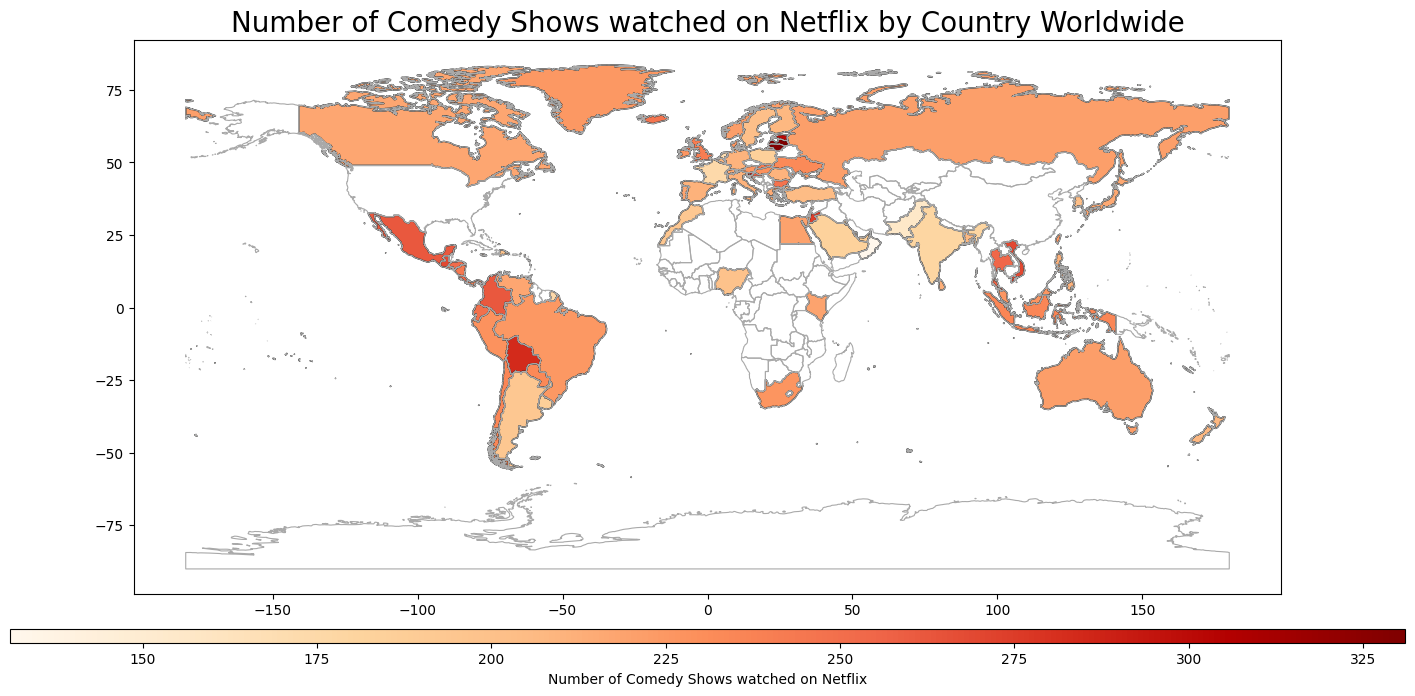

In [38]:
world = gpd.read_file('/Users/denyceng/CODE1161dataproject/ne_50m_admin_0_countries')

# merges the world GeoDataFrame with another DataFrame called dramatic_df. 
# The merge is done on the columns 'SOVEREIGNT' from world and 'country_name' from dramatic_df. 
# The how='left' argument means that all rows from the world dataset will be retained, and only matching rows from dramatic_df will be added
world = world.merge(funny_df, left_on='SOVEREIGNT', right_on='country_name', how='left') 

fig, ax = plt.subplots(1, 1, figsize=(18, 9)) #creates a Matplotlib figure (fig) and a set of axes (ax).
world.boundary.plot(ax=ax,edgecolor= 'darkgray',lw=0.8) #plots the boundaries of the geometries from GeoDataFrame on axes. This step outlines the countries borders.
world.plot(column='funny_count', #specifies the column in the GeoDataFrame to use for coloring the map. Here, it's likely a count of drama shows.
           ax=ax,
           legend=True, #adds a legend (colorbar) to the plot
           cmap='OrRd', #sets the colormap to "Orange-Red,"
           edgecolor='black',
           legend_kwds={'label': "Number of Comedy Shows watched on Netflix",
                        'orientation': "horizontal",'pad':0.05, 'aspect':100, 'spacing':'proportional'}) # It sets the label of the colorbar and makes the orientation of the legend horizontal.
ax.tick_params(axis='both', labelsize=10) #sets the font size of the tick labels on X and Y axis to 45.

plt.title('Number of Comedy Shows watched on Netflix by Country Worldwide',fontsize=20)
plt.show()


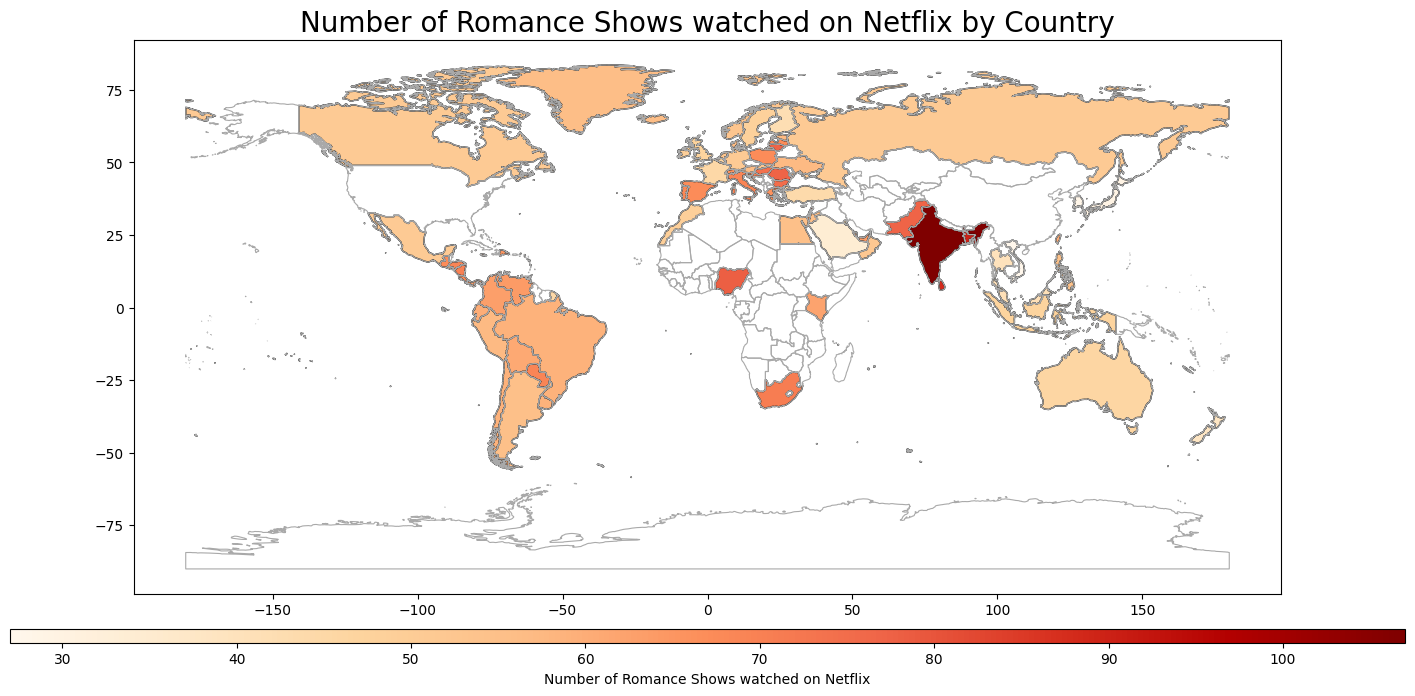

In [39]:

world = gpd.read_file('/Users/denyceng/CODE1161dataproject/ne_50m_admin_0_countries')

# merges the world GeoDataFrame with another DataFrame called dramatic_df. 
# The merge is done on the columns 'SOVEREIGNT' from world and 'country_name' from dramatic_df. 
# The how='left' argument means that all rows from the world dataset will be retained, and only matching rows from dramatic_df will be added
world = world.merge(romantic_df, left_on='SOVEREIGNT', right_on='country_name', how='left') #

fig, ax = plt.subplots(1, 1, figsize=(18, 9)) #creates a Matplotlib figure (fig) and a set of axes (ax).
world.boundary.plot(ax=ax,edgecolor= 'darkgray',lw=0.8) #plots the boundaries of the geometries from GeoDataFrame on axes. This step outlines the countries borders.
world.plot(column='romantic_count', #specifies the column in the GeoDataFrame to use for coloring the map. Here, it's likely a count of drama shows.
           ax=ax,
           legend=True, #adds a legend (colorbar) to the plot
           cmap='OrRd', #sets the colormap to "Orange-Red,"
           edgecolor='black',
           legend_kwds={'label': "Number of Romance Shows watched on Netflix",
                        'orientation': "horizontal",'pad':0.05, 'aspect':100, 'spacing':'proportional'}) # It sets the label of the colorbar and makes the orientation of the legend horizontal.
ax.tick_params(axis='both', labelsize=10) #sets the font size of the tick labels on X and Y axis to 45.

plt.title('Number of Romance Shows watched on Netflix by Country',fontsize=20)
plt.show()

## Let us look at India!

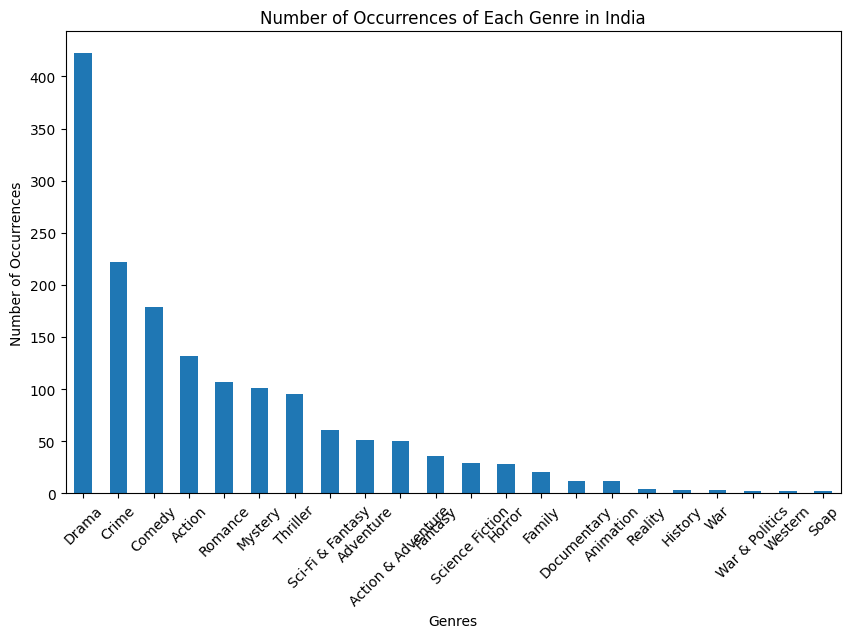

In [45]:
import matplotlib.pyplot as plt
from collections import Counter
import ast
from ast import literal_eval

pd.options.mode.chained_assignment = None 
country_name= 'India'
india_data = netflix_data[netflix_data['country_name'] == 'India']

def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

india_data['genres'] = india_data['genres'].apply(safe_eval)

# Create a list of all genres
all_genres = [genre for sublist in india_data['genres'] for genre in sublist]

# Count occurrences of each genre
genre_counts = pd.Series(all_genres).value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.xlabel('Genres')
plt.ylabel('Number of Occurrences')
plt.title(f'Number of Occurrences of Each Genre in {country_name}')
plt.xticks(rotation=45)
plt.show()

pd.options.mode.chained_assignment = 'warn'

## What about the rest of the world?

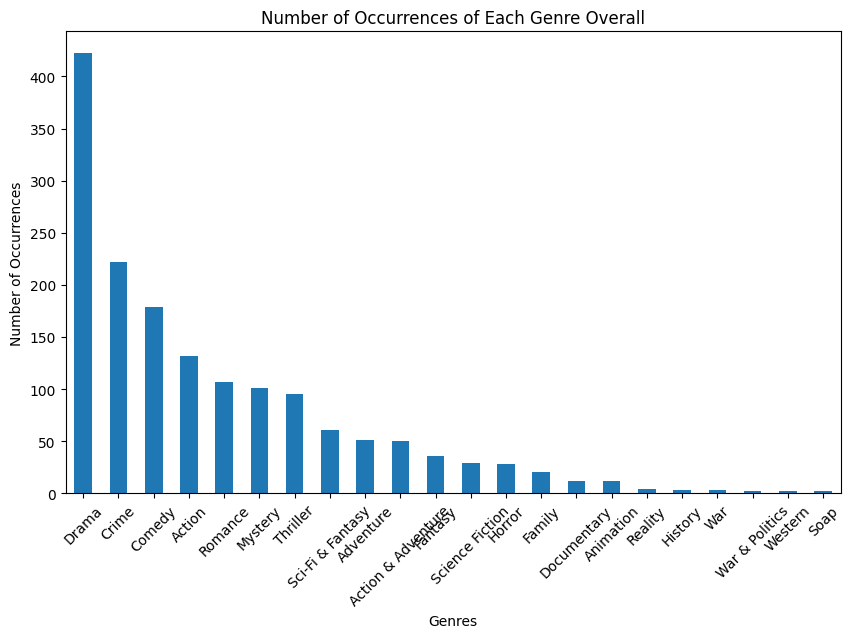

In [ ]:


netflix_data['genres'] = netflix_data['genres'].apply(safe_eval)

# Create a list of all genres
all_genres = [genre for sublist in india_data['genres'] for genre in sublist]

# Count occurrences of each genre
genre_counts = pd.Series(all_genres).value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.xlabel('Genres')
plt.ylabel('Number of Occurrences')
plt.title('Number of Occurrences of Each Genre Overall')
plt.xticks(rotation=45)
plt.show()